In [1]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get

In [2]:
# imports
import pandas as pd
import geopandas as gpd
import json, requests
from pathlib import Path
import os

# Define the path
os.chdir("siads_699_mads_capstone")
print("Current working directory:", os.getcwd())

# RAW_PATH = Path("../data/raw/wzdx_tx/")
RAW_PATH = Path("/datasets/_deepnote_work/siads_699_mads_capstone/data/raw/");
print(RAW_PATH)
os.makedirs(RAW_PATH, exist_ok=True)

url = "https://datahub.transportation.gov/resource/69qe-yiui.json?$limit=1000"

data = requests.get(url).json()
print(f"Records pulled: {len(data)}")

df = pd.json_normalize(data)

df.to_csv(RAW_PATH / "txdot_wzdx_sample.csv", index=False)
print("TxDOT feed saved.")

Current working directory: /datasets/_deepnote_work/siads_699_mads_capstone
/datasets/_deepnote_work/siads_699_mads_capstone/data/raw
Records pulled: 36
TxDOT feed saved.


In [3]:
import mlflow
print("MLflow version:", mlflow.__version__)

MLflow version: 3.6.0


In [4]:
import mlflow

mlflow.set_tracking_uri("mlruns") 
mlflow.set_experiment("WorkZonePrediction")
print("MLflow tracking locally in ./mlruns")

/root/venv/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
MLflow tracking locally in ./mlruns


In [5]:
from siads_699_mads_capstone.src.data.cleanup_wzdx import run_txdot_csv_pipeline
run_txdot_csv_pipeline()

Loading local CSV from /datasets/_deepnote_work/siads_699_mads_capstone/data/raw/Texas_DOT_Work_Zone_Data.csv
Loaded 2180 rows, 31 columns.
Selected 12 relevant columns.
Extracted 1829 coordinate pairs.
Cleaning and enriching data...
Duration column summary:
count     2180.000000
mean        35.843818
std        290.963342
min          0.000000
25%         12.000000
50%         23.999722
75%         23.999722
max      11760.000000
Name: duration_hr, dtype: float64
Retained 1829 valid rows out of 2180.
Saved cleaned dataset:
  CSV -> /work/siads_699_mads_capstone/data/clean/txdot_wzdx_clean.csv

TxDOT Work Zone CSV ingestion complete!


In [6]:
import pandas as pd
df = pd.read_csv("/work/siads_699_mads_capstone/data/raw/Texas_DOT_Work_Zone_Data.csv")
print(df.columns)
print(df.head(2))

Index(['road_event_feed_info_feed_update_date', 'road_event_feed_info_version',
       'road_event_id', 'subidentifier', 'road_name', 'road_number',
       'direction', 'beginning_cross_street', 'ending_cross_street',
       'beginning_milepost', 'ending_milepost', 'beginning_accuracy',
       'ending_accuracy', 'start_date', 'end_date', 'start_date_accuracy',
       'end_date_accuracy', 'event_status', 'total_num_lanes',
       'vehicle_impact', 'workers_present', 'reduced_speed_limit',
       'restrictions', 'description', 'issuing_organization', 'creation_date',
       'update_date', 'types_of_work', 'lanes', 'geometry_linestring',
       'geometry_multipoint'],
      dtype='object')
  road_event_feed_info_feed_update_date  road_event_feed_info_version  \
0               2024 Apr 02 08:43:42 PM                             2   
1               2024 Apr 02 08:43:42 PM                             2   

                     road_event_id subidentifier road_name  road_number  \
0  ELP_20

In [7]:
import pandas as pd, re
file_path = "data/raw/Texas_DOT_Work_Zone_Data.csv"
df = pd.read_csv(file_path)
val = df["geometry_multipoint"].iloc[0]
print(val)
print(re.findall(r"[-\d.]+", val))

MULTIPOINT ((-106.323587 31.676631))
['-106.323587', '31.676631']


In [8]:
import pandas as pd

df = pd.read_csv("data/raw/Texas_DOT_Work_Zone_Data.csv")
print("Sample start_date:", df['start_date'].iloc[0])
print("Sample end_date:", df['end_date'].iloc[0])

Sample start_date: 2024 Apr 02 12:00:00 AM
Sample end_date: 2024 Apr 02 11:59:59 PM


In [9]:
!python src/data/txdot_usaccidents.py

Loading TxDOT Work Zone data...
Loaded 1829 work zone records.
Sample start_date: 2024-01-02 13:00:00 to 2024-04-26 02:00:00
Loading TX-only US Accidents subset...
Traceback (most recent call last):
  File "/datasets/_deepnote_work/siads_699_mads_capstone/src/data/txdot_usaccidents.py", line 107, in <module>
    main()
  File "/datasets/_deepnote_work/siads_699_mads_capstone/src/data/txdot_usaccidents.py", line 93, in main
    tx_acc = load_tx_accidents()
  File "/datasets/_deepnote_work/siads_699_mads_capstone/src/data/txdot_usaccidents.py", line 33, in load_tx_accidents
    df = pd.read_csv(US_ACCIDENTS_PATH, usecols=usecols)
  File "/root/venv/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 948, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/root/venv/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 611, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/root/venv/lib/python3.10/site-packages/pandas/io/parsers/

In [10]:
#!python src/features/aggregate_workzone_features.py
!python /work/siads_699_mads_capstone/src/features/aggregate_workzone_features.py

Loading merged work-zone crash dataset
Loaded 338556 merged records from 1653 unique work zones.
Aggregating crash statistics by work zone
Saved aggregated feature table - /work/siads_699_mads_capstone/data/models/workzone_features.csv
                     road_event_id road_name  ...  avg_wind_mph high_risk
0  ELP_2022-01-27_00083+2024-04-02  Americas  ...      8.430159         0
1  ELP_2022-01-27_00083+2024-04-03  Americas  ...      8.430159         0
2  ELP_2022-01-27_00083+2024-04-04  Americas  ...      8.430159         0
3  ELP_2022-01-27_00083+2024-04-05  Americas  ...      8.430159         0
4  ELP_2022-01-27_00083+2024-04-06  Americas  ...      8.430159         0
5  ELP_2022-01-27_00083+2024-04-07  Americas  ...      8.430159         0
6  ELP_2022-01-27_00083+2024-04-08  Americas  ...      8.430159         0
7  ELP_2022-01-27_00083+2024-04-09  Americas  ...      8.430159         0
8  ELP_2022-06-30_00025+2024-04-06     IH-10  ...      7.300000         0
9  ELP_2022-01-27_00083+

<AxesSubplot: >

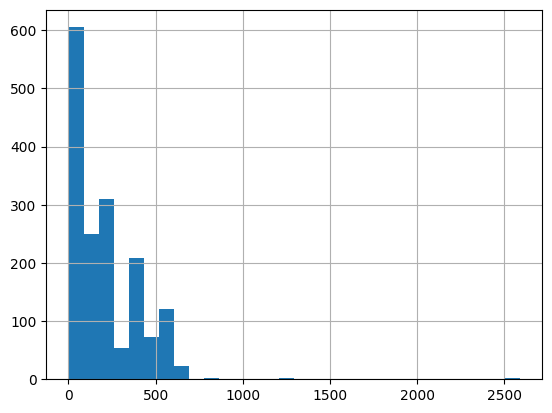

In [11]:
#EDA
import pandas as pd

df = pd.read_csv("/work/siads_699_mads_capstone/data/models/workzone_features.csv")
df.describe()
df["crash_count"].hist(bins=30)

Loaded 1653 work zones with 14 features.


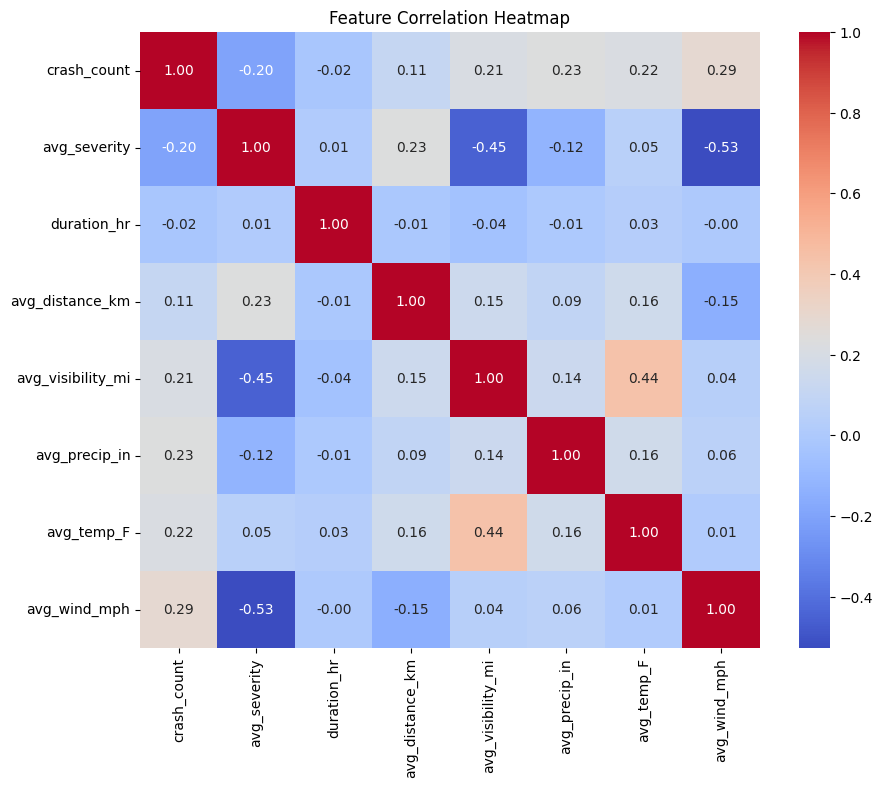

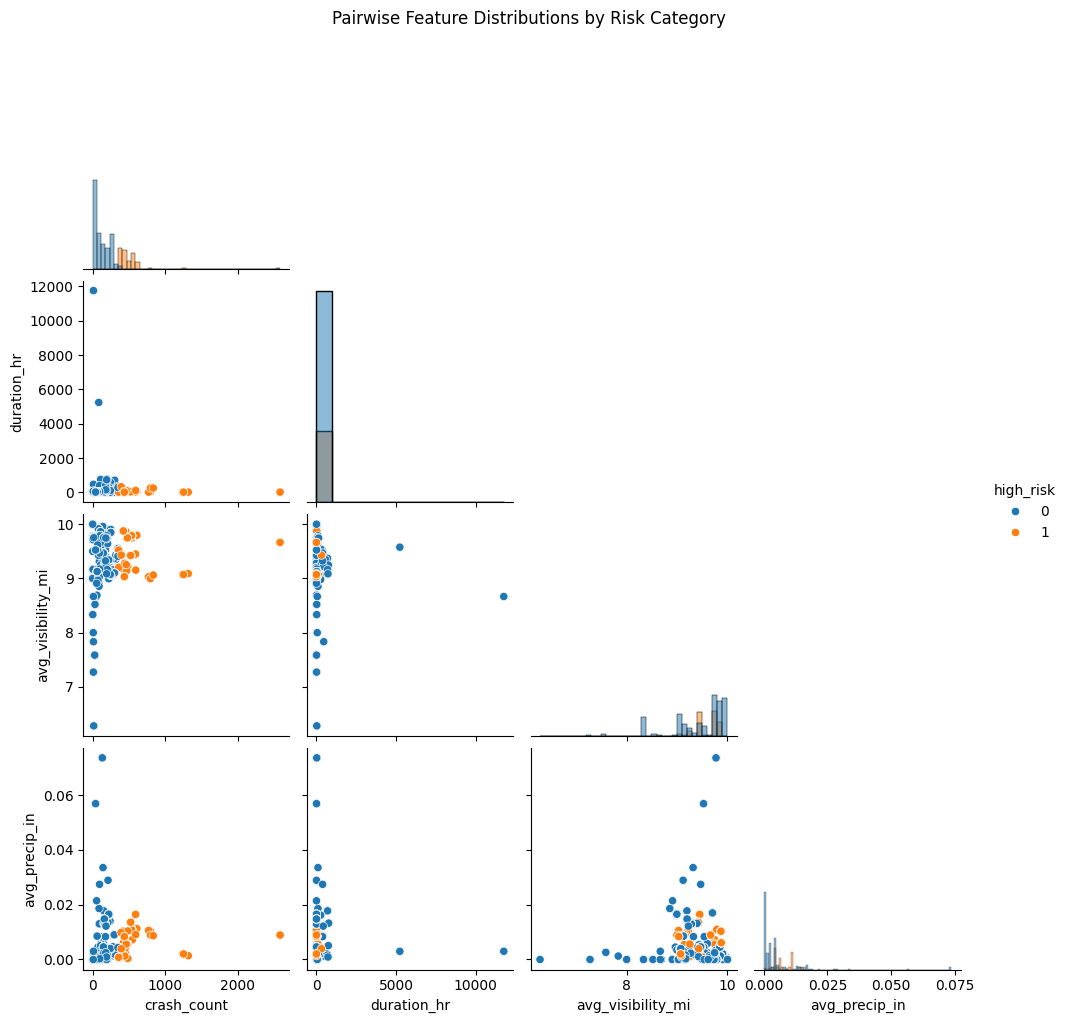

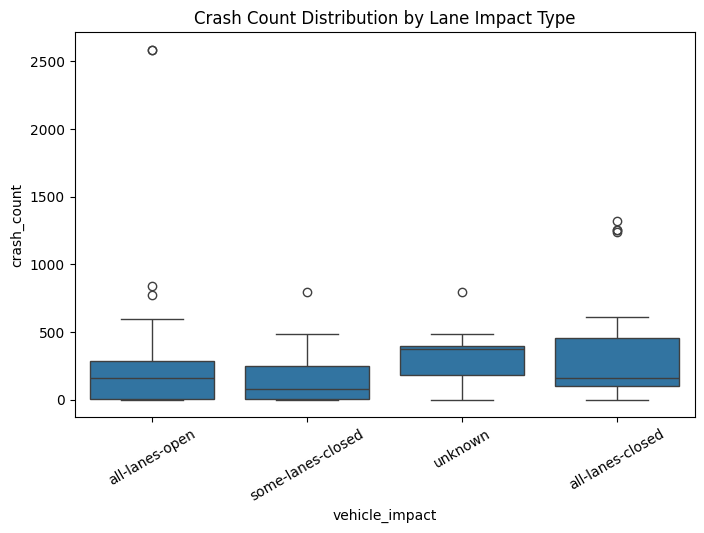

Explained variance ratio: [0.25884287 0.19049631]


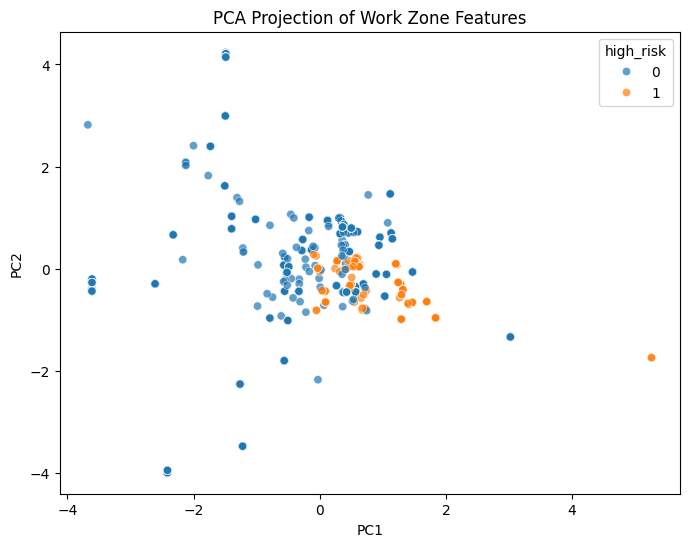

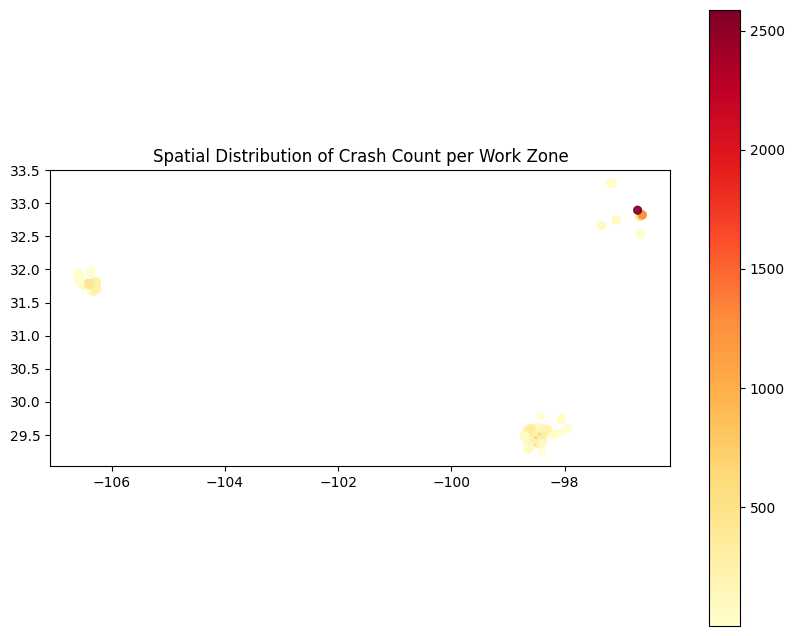

In [12]:
#Advanced EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import geopandas as gpd
from shapely.geometry import Point

df = pd.read_csv("/work/siads_699_mads_capstone/data/models/workzone_features.csv")

print(f"Loaded {len(df)} work zones with {df.shape[1]} features.")
df.head()

#Correlation Heatmap
numeric_cols = ["crash_count", "avg_severity", "duration_hr", "avg_distance_km", "avg_visibility_mi", "avg_precip_in", 
    "avg_temp_F", "avg_wind_mph"
]
corr = df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

#Pairplot
sns.pairplot(df, vars=["crash_count","duration_hr","avg_visibility_mi","avg_precip_in"],
             hue="high_risk", diag_kind="hist", corner=True)
plt.suptitle("Pairwise Feature Distributions by Risk Category", y=1.02)
plt.show()

#Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="vehicle_impact", y="crash_count")
plt.title("Crash Count Distribution by Lane Impact Type")
plt.xticks(rotation=30)
plt.show()

#PCA
X = df[numeric_cols].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1","PC2"])
pca_df["high_risk"] = df["high_risk"]
print("Explained variance ratio:", pca.explained_variance_ratio_)
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="high_risk", alpha=0.7)
plt.title("PCA Projection of Work Zone Features")
plt.show()

#Spatial map
try:
    geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    gdf.plot(ax=ax, column="crash_count", cmap="YlOrRd", legend=True, markersize=30, alpha=0.7)
    plt.title("Spatial Distribution of Crash Count per Work Zone")
    plt.show()
except Exception as e:
    print("Spatial map skipped:", e)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>